<a href="https://colab.research.google.com/github/andy-j-block/lymphoma_classifier/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO:

- continue tinkering with data generation
    - transforms for the validation set as well?
- build custom model?
- train models
- fix inception input vs kernel size mismatch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andy-j-block/lymphoma_classifier/blob/master/Classifier.ipynb)

# Background

This project is a multiclass classification of three different types of lymphoma: 

- chronic lymphocytic leukemia (CLL)
- follicular lymphoma (FL) 
- mantle cell lymphoma (MCL)

I was diagnosed with Hodgkin's Lymphoma myself back in 2013 so this project has a special personal relevance to me.

The dataset that will be utilized throughout this project is 374 immunostained biopsy images of the three different subtypes of lymphoma.  The data itself can be found [here](https://www.kaggle.com/andrewmvd/malignant-lymphoma-classification).  Credit to the authors of the dataset:

> Orlov, Nikita & Chen, Wayne & Eckley, David & Macura, Tomasz & Shamir, Lior & Jaffe, Elaine & Goldberg, Ilya. (2010). Automatic Classification of Lymphoma Images With Transform-Based Global Features. IEEE transactions on information technology in biomedicine : a publication of the IEEE Engineering in Medicine and Biology Society. 14. 1003-13. 10.1109/TITB.2010.2050695.

#Results

# Setup and Data Import
This first section will comprise of four different tasks:

- determining whether the user is utilizing a hosted or local runtime
- importing the data from GitHub
- opening each image using Pillow and formatting them as an array in NumPy
- storing the image data in a Pandas DataFrame

The additional task of downloading the latest version of the albumentations library will also be performed in this step if the user is utilizing a hosted runtime.  That way, if the kernel needs to be restarted to incorporate this change, it is done towards the beginning of the script.



###Imports and function definitions

In [ ]:
from PIL import Image
import os
from matplotlib import pyplot as plt
from os.path import abspath
import numpy as np
import pandas as pd
import random
import gc

In [ ]:
def running_hosted():

    if 'content' in os.getcwd():
        hosted = True
      
    else:
        hosted = False
        %autosave 120
    
    if hosted:
       print(f'This notebook is running hosted') 
    
    else:
        print(f'This notebook is running locally\nAutosave is set to 120 seconds')

    return hosted

############

def colab_setup():

    %cd -q /content/
    
    #check if git clone already performed
    if not os.path.isdir('./lymphoma_classifier'):
        !git clone https://github.com/andy-j-block/lymphoma_classifier.git
        
    %cd -q /content/lymphoma_classifier
    current_dir = os.getcwd()
    print(f"Current directory is '{current_dir}'")


############      

def load_images(imgs_main_dir):
    
    # get cancer type strings
    cancer_types = [type_ for type_ in os.listdir(imgs_main_dir)]

    # get directories where images are stored
    img_dirs = [os.path.join(imgs_main_dir, type_) for type_ in cancer_types]
    
    # read images into a list
    imgs = []

    for i, img_dir in enumerate(img_dirs):       
        img_paths = os.listdir(img_dir)
        
        for j in img_paths:

            # pass thru all the image files per image directory, read the image,
            # add it to the images list
            img_path = os.path.join(img_dirs[i], j)
            img_array = Image.open(img_path)
            img_array = np.asarray(img_array)        
            imgs.append((cancer_types[i], img_array))
                
    return imgs

###Local or hosted runtime

I like to use Google Colab for its hosted runtime features so I include a check to see if the notebook is being run locally or hosted.

In [ ]:
hosted = running_hosted()

This notebook is running hosted


If the notebook is being run from a hosted runtime, the Git repo is cloned into the working directory.  Otherwise, it is assumed that the user has cloned the original Git repo and the dataset is saved on their machine.

In [ ]:
if hosted:
    colab_setup()

Cloning into 'lymphoma_classifier'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 535 (delta 60), reused 3 (delta 1), pack-reused 416
Receiving objects: 100% (535/535), 1.43 GiB | 28.26 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Checking out files: 100% (380/380), done.
Current directory is '/content/lymphoma_classifier'


For whatever reason, the default installed version of the Albumentations library on Google Colab is a very outdated one.  Fetching the latest version of albumentations library if running on hosted machine.

In [ ]:
if hosted:
    !pip install albumentations --upgrade -q

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 952kB 38.8MB/s 


###Data import and image preview

The images will now be imported and saved in an object.  As a sanity check, display the first image label, the first few entries of the first image array, and then show the first image in a manageable reduced size.

First entry cancer type: CLL

First entry image array: [[[141 103 145]
  [131 103 143]
  [117  92 130]
  ...
  [ 65  61 116]
  [ 98  97 136]
  [129 129 156]]

 [[133 103 143]
  [124 103 144]
  [112  92 133]
  ...
  [ 63  61 116]
  [ 97  97 142]
  [129 129 156]]

 [[122  95 138]
  [115  95 138]
  [105  85 128]
  ...
  [ 64  59 113]
  [ 87  83 134]
  [121 121 164]]]
continued...

First entry image:


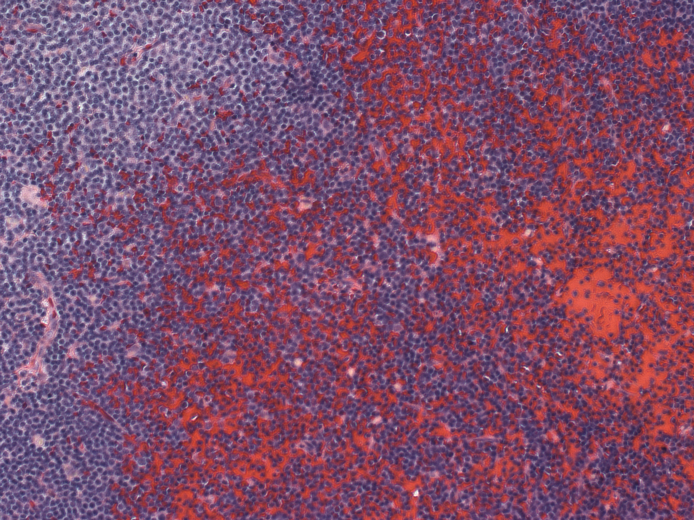

In [ ]:
imgs = load_images('./Images')
print(f'First entry cancer type: {imgs[0][0]}\n')
print(f'First entry image array: {imgs[0][1][:3]}\ncontinued...\n')
print('First entry image:')
Image.fromarray(imgs[0][1]).reduce(2)

###Create DataFrame

Create a pandas dataframe object and confirm its shape.

In [ ]:
df = pd.DataFrame(imgs, columns=['cancer_type', 'img_array'])
df.head(3)

,cancer_type,img_array
0,CLL,"[[[141, 103, 145], [131, 103, 143], [117, 92, ..."
1,CLL,"[[[84, 80, 112], [77, 80, 115], [71, 75, 113],..."
2,CLL,"[[[144, 134, 149], [142, 134, 148], [144, 136,..."


In [ ]:
print(df.shape)

(374, 2)


# Exploratory Data Analysis

Given that these images are rich in latent features and confined to a low number of labels, the exploratory data analysis here is not substantial, as the model itself is going to be doing most of the work.  Class distribution will be explored, as well as ensuring that the images are all the same size and their RGB arrays are within the expected intensity range of [0, 255].  The target column will be label encoded and a random sample of each of the cancer types will be shown in full image form.

###Imports and function definitions

In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [ ]:
def show_value_counts(series):

    print(f'The value counts are:\n{series.value_counts()}')

    percentages = [i/len(df) for i in series.value_counts().values]
    percentages = [round(i,2) for i in percentages]

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    bar_chart=ax.bar(x=series.value_counts().index, 
                    height=series.value_counts().values)

    def add_labels(bar_chart, text_labels):
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    text_labels[i],
                    ha='center', va='bottom')
            
    add_labels(bar_chart, percentages)

    plt.title('Count by cancer type with percentages as text')
    plt.show()

############

def get_image_dims(data, set_=True):

    img_heights = []
    img_widths = []

    # widths and heights if input is pandas series 
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            img = data.iloc[i]
            height, width = img.shape[0], img.shape[1]
            img_heights.append(height)
            img_widths.append(width)

        if set_:
            # cast to set to eliminate duplicates
            img_heights = set(img_heights)
            img_widths = set(img_widths)
                
            print('Image heights are: ', img_heights)
            print('Image widths are: ', img_widths)
    
    # widths and heights if input is torchvision dataset
    else:

        for i in range(len(data)):
            width, height = data[i][0].shape[2], data[i][0].shape[1]
            img_heights.append(height)
            img_widths.append(width)

        # cast to set to eliminate duplicates
        img_heights = set(img_heights)
        img_widths = set(img_widths)
            
        print('Image heights are: ', img_heights)
        print('Image widths are: ', img_widths)

    if not set_:
        img_heights = min(img_heights)
        img_widths = min(img_widths)

    return img_heights, img_widths

############

def get_intensity_range(data):

    maxs = []
    mins = []

    # intesities if input is pandas series
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            maxs.append(np.amax(data.values[i]))
            mins.append(np.amin(data.values[i]))

    # intensities if input is torchvision dataset
    else:

        for i in range(len(data)):
            maxs.append(torch.max(data[i][0]))
            mins.append(torch.min(data[i][0])) 

    print(f'The highest intesity in the range: {max(maxs)}')
    print(f'The lowest intesity in the range: {min(mins)}')

############

def get_random_image(data, decode_dict, figsize=(30,10)):

    rand_imgs = []
    rand_idxs = []

    if type(data) is pd.DataFrame:
        for i in range(3):
            data_by_type = data[data['cancer_type']==i]
            rand_img = random.choice(data_by_type['img_array'].values)
            rand_imgs.append(rand_img)

        fig, axs = plt.subplots(1, len(rand_imgs), figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {decode_dict[i]}')
            axs[i].imshow(img)

    else:

        for _ in range(4):
            
            # get random index and store for later
            data_idxs = range(len(data))
            rand_idx = random.choice(data_idxs)
            rand_idxs.append(rand_idx)
            
            # get image with random index and convert RGB array back to image
            rand_img = data[rand_idx][0]
            rand_img = rand_img.permute(1, 2, 0)
            rand_imgs.append(rand_img)

        fig, axs = plt.subplots(1, 4, figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {decode_dict[int(data[rand_idxs[i]][1])]}')
            axs[i].imshow(img)

###Class distribution and Label Encoding

Let's check the count of each cancer type and label encode them.

The value counts are:
FL     139
MCL    122
CLL    113
Name: cancer_type, dtype: int64


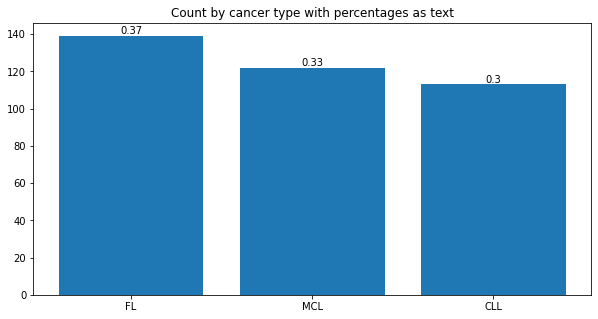

In [ ]:
show_value_counts(df['cancer_type'])

In [ ]:
encode_dict = {'CLL':0, 'FL':1, 'MCL':2}
decode_dict = {0: 'CLL', 1: 'FL', 2: 'MCL'}
df['cancer_type']=df['cancer_type'].replace(encode_dict)
df['cancer_type'].value_counts()

1    139
2    122
0    113
Name: cancer_type, dtype: int64

###Image size and color intensity

Check the 

In [ ]:
img_heights, img_widths = get_image_dims(df['img_array'])
img_heights_int, img_widths_int = get_image_dims(df['img_array'], set_=False)

Image heights are:  {1040}
Image widths are:  {1388}


Single value sets mean all images with the same height and width.  Let's confirm the pixel color intensity range

In [ ]:
get_intensity_range(df['img_array'])

The highest intesity in the range: 255
The lowest intesity in the range: 2


I think it's safe to say that these RGB color values range from (0,255).  Color scaling later on will reflect this range

###Sample images

Let's look at a random image of each cancer type.

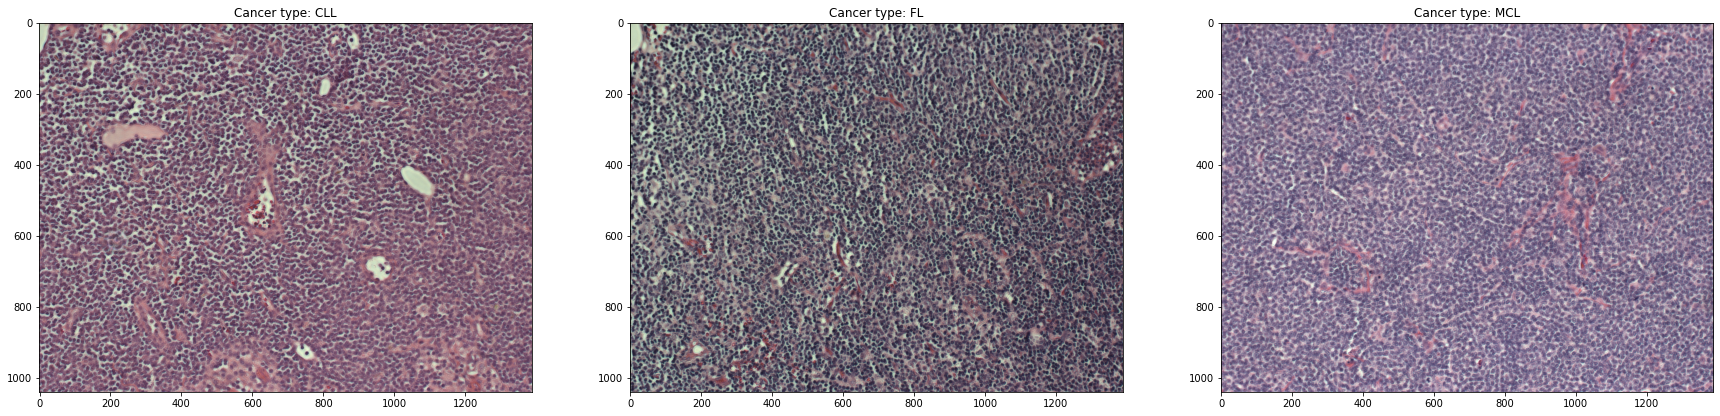

In [ ]:
get_random_image(df, decode_dict)

# Prepare Data

###Imports and function definitions

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def visualize_sets(full_series, train_series, test_series, titles):

    series = [full_series, train_series, test_series]

    percentages = []
    
    for i, series_ in enumerate(series):

        percentage = [j/len(series_) for j in series_.value_counts().values]
        percentage = [round(j,2) for j in percentage]
        percentages.append(percentage)

    fig, ax = plt.subplots(1,len(series),figsize=(20,5))

    dfs=[]

    for i, series_ in enumerate(series):

        df = ax[i].bar(x=series_.value_counts().index, 
                    height=series_.value_counts().values)
        
        dfs.append(df)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_charts, text_labels):
        for i, chart in enumerate(bar_charts):
            for j, bar in enumerate(chart):
                height = bar.get_height()
                ax[i].text(bar.get_x() + bar.get_width()/2., height,
                        text_labels[i][j],
                        ha='center', va='bottom')# rotation=0?)
            
    autolabel(dfs, percentages)

    for i, title in enumerate(titles):
        ax[i].set_title(title)
    
    plt.show()

###Train test split

We want to create a holdout test set now, but we don't want to split the target variable yet from the image and its path.  When we move onto data generation, we need to keep the target available, so we will just separate the dataframe as a whole.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['cancer_type'], random_state=42) 

In [ ]:
print(df_train.shape, df_test.shape)

(299, 2) (75, 2)


Store the training and validation data before splitting for later use in normalization transforms

In [ ]:
df_train_and_val = df_train.copy()

###Set visualizing

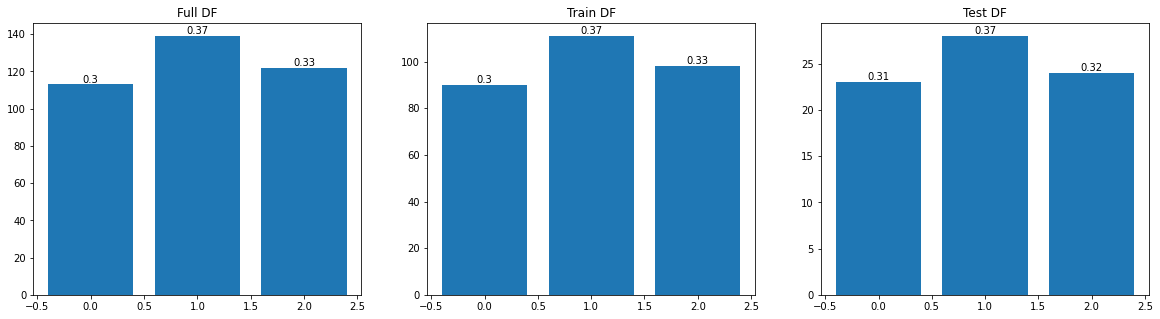

In [ ]:
visualize_sets(df['cancer_type'], df_train['cancer_type'], df_test['cancer_type'], ['Full DF', 'Train DF', 'Test DF'])

In [ ]:
df_test.head(3)

,cancer_type,img_array
143,2,"[[[174, 104, 113], [177, 104, 114], [170, 97, ..."
99,0,"[[[198, 155, 144], [200, 155, 149], [195, 148,..."
211,2,"[[[145, 137, 151], [156, 137, 148], [169, 150,..."


Let's just reset the index here for clarity.

In [ ]:
df_test.reset_index(inplace=True, drop=True)
df_test.head(3)

,cancer_type,img_array
0,2,"[[[174, 104, 113], [177, 104, 114], [170, 97, ..."
1,0,"[[[198, 155, 144], [200, 155, 149], [195, 148,..."
2,2,"[[[145, 137, 151], [156, 137, 148], [169, 150,..."


In [ ]:
df_test['cancer_type'].value_counts()

1    28
2    24
0    23
Name: cancer_type, dtype: int64

###Train val split

The data needs to be split again before generation can occur, that was the validation set generated data doesn't get into the training set.

In [ ]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)

In [ ]:
df_train.head(3)

,cancer_type,img_array
247,1,"[[[122, 117, 140], [129, 117, 141], [129, 115,..."
88,0,"[[[58, 40, 74], [58, 40, 72], [59, 43, 69], [6..."
220,2,"[[[123, 67, 81], [121, 67, 82], [123, 62, 77],..."


Again, let's reset our indices.

In [ ]:
df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

# Data Generation

### Imports and function definitions

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.special import binom
import seaborn as sns

In [ ]:
class lymphoma_images_dataset(Dataset):

    def __init__(self, type_, imgs, transform=None):
        self.type_ = type_
        self.imgs = imgs
        self.transform = transform
      
    def __len__(self):
        return len(self.type_)
    
    def __getitem__(self, idx):
        
        img = self.imgs.iloc[idx]
        label = torch.tensor(int(self.type_.iloc[idx]))

        if self.transform:
            img = self.transform(img)

        return (img, label)


############


def define_dataset(type_series, image_series, transform=None, batch_size=4, shuffle=True, num_workers=2):

    data = lymphoma_images_dataset(type_series, image_series, transform=transform)
    loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return data, loader


############


def create_data(num_passes, transforms, phase, orig_df):

    new_df = orig_df.copy()
    orig_df_len = len(orig_df)
    cols = new_df.columns

    # generate new data
    for i in range(num_passes):

        for j in range(len(orig_df)):

            # perform transformations
            new_array = transforms[phase](image=orig_df['img_array'].values[j])
            new_array = transforms['normalize_resize'](image=new_array['image'])
            new_array = new_array['image']

            new_data = {cols[0]:orig_df[cols[0]].iloc[j],
                        cols[1]:new_array,
                        }

            new_df = new_df.append(new_data, ignore_index=True)

    # normalize original data
    for i in range(orig_df_len):
        new_array = transforms['normalize_resize'](image=new_df['img_array'].values[i])
        new_df.at[i, 'img_array'] = new_array['image']
    
    return new_df


############


def plot_num_transforms(probabilities, num_poss_transforms):

    prob_dict = {}

    # define probabilities of specific number of transforms
    for p in probabilities:
        p_comp = 1-p
        prob_dict[p] = {i:p**i * p_comp**(num_poss_transforms-i) * binom(num_poss_transforms, i) \
                        for i in range(num_poss_transforms+1)}
    
    fig, axs = plt.subplots(1,len(probabilities), figsize=(30,10))
    fig.suptitle('Probability of a given number of transforms with varying p values')

    for i, p in enumerate(probabilities):
        keys = list(prob_dict[p].keys())
        values = [prob_dict[p][k] for k in keys]
        sns.barplot(x=keys, y=values, ax=axs[i])
        axs[i].set_title(f'p={p}')

###Device detection

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.backends.cudnn.benchmark = True

cuda


###Dataset and dataloader

Define dataset class for dataloader to call

Set useful constants

In [ ]:
p = 0.3
p_comp = 1-p

tl_means = (0.485, 0.456, 0.406)
tl_stds = (0.229, 0.224, 0.225)

#resize_factor = img_widths_int/4

Determine transform probabilities

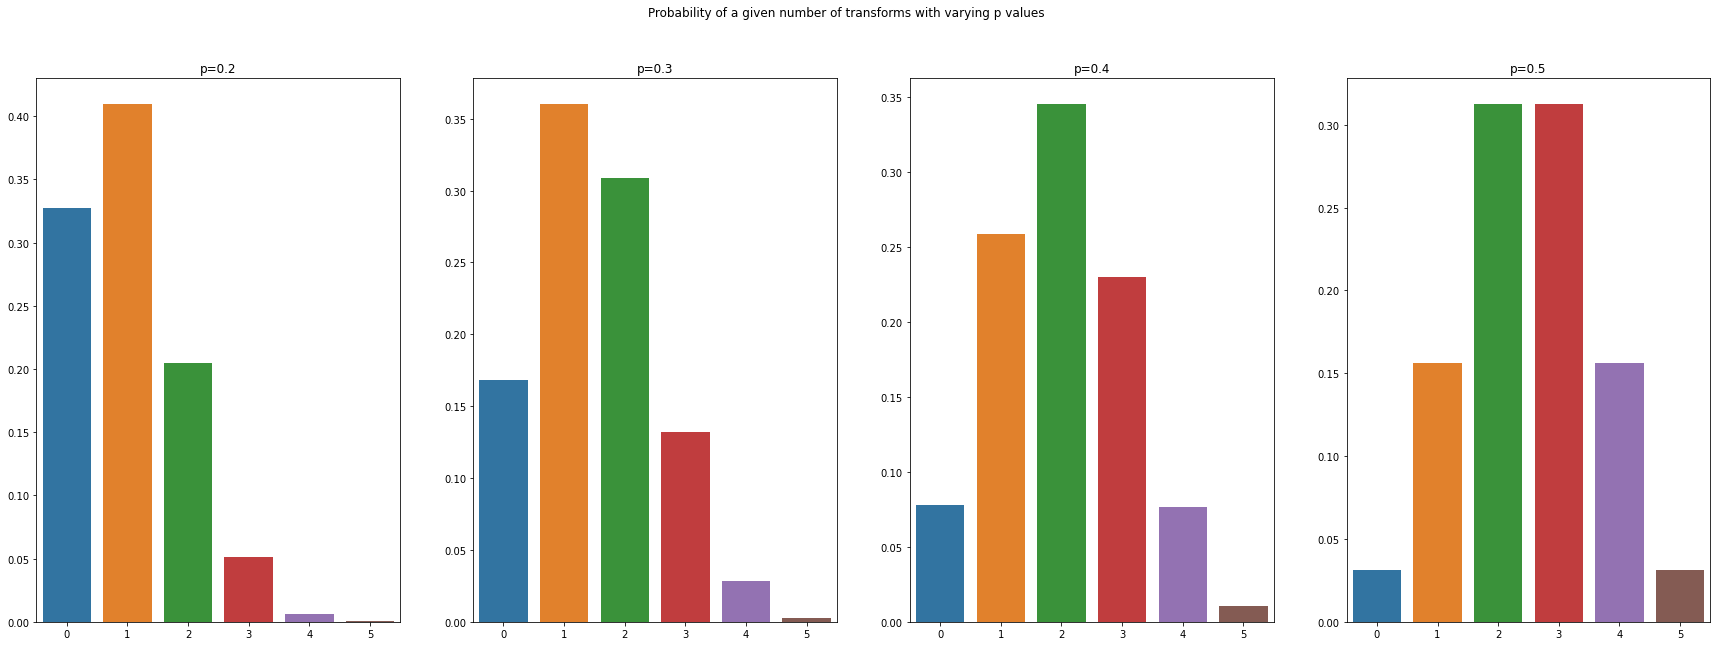

In [ ]:
plot_num_transforms([0.2,0.3,0.4,0.5], 5)

In [ ]:
#LongestMaxSize interpolation strategy?
#validation transformations?

alb_transform_dict = {'train': A.Compose([A.HorizontalFlip(p=p),
                                          A.VerticalFlip(p=p),
                                          A.ColorJitter(p=p),
                                          A.Rotate(limit=10, interpolation=cv2.BORDER_CONSTANT, p=p),
                                          A.RGBShift(p=p)
                                          ]),
                      
                      'valid': A.Compose([A.HorizontalFlip(p=p),
                                          A.VerticalFlip(p=p),
                                          A.ColorJitter(p=p),                                          
                                          A.Rotate(limit=10, interpolation=cv2.BORDER_CONSTANT, p=p),
                                          A.RGBShift(p=p)
                                          ]),
                      
                      'normalize_resize': A.Compose([A.Normalize(mean=tl_means, std=tl_stds),
                                                     A.LongestMaxSize(resize_factor)
                                                     ]),
                      }


In [ ]:
df_train_aug = create_data(4, alb_transform_dict, 'train', df_train)
df_valid_aug = create_data(0, alb_transform_dict, 'valid', df_valid)

In [ ]:
print(df_train_aug.head(2), '\n', df_train_aug.tail(2))
print(df_valid_aug.head(2), '\n', df_valid_aug.tail(2))

Dataloader

In [ ]:
train_data_8batch, train_loader_8batch = define_dataset(df_train_aug['cancer_type'], df_train_aug['img_array'], batch_size=1, transform=transforms.ToTensor())
valid_data_8batch, valid_loader_8batch = define_dataset(df_valid_aug['cancer_type'], df_valid_aug['img_array'], batch_size=1, transform=transforms.ToTensor())

datasets = {
            'train': train_data_8batch,
            'valid': valid_data_8batch
            }
dataloaders = {
               'train': train_loader_8batch,
               'valid': valid_loader_8batch
              }

###Confirm image dimensions and intensities

In [ ]:
img_heights, img_widths = get_image_dims(train_data_8batch)

In [ ]:
get_intensity_range(train_data_8batch)

###Visualize some generated data

In [ ]:
get_random_image(train_data_8batch, decode_dict)


# Model Build

In [ ]:
import torch.optim as optim

###Bespoke model architectures

In [ ]:
class shallow_net(nn.Module):
    # this network will consist of three CRB layers before a fully connected

    def __init__(self):
        super(shallow_net, self).__init__()

        self.conv1_k5 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        # initialize weights?? nn.init.kaiming_uniform_, nn.init.xavier_uniform_
        self.ap = nn.AvgPool2d(2)
        self.fc = nn.Linear(1408, 3)

    
    def forward(self, x):
        x = F.relu(self.ap(self.conv1(x)))
        x = x.view(-1)
        x = self.fc(x)
        return F.log_softmax(x)

class medium_net(shallow_net):
     # this network will consist of five CRB layers before a fully connected
    pass

class deep_net(nn.Module):
    # this network will consist of eight CRB layers before a fully connected
    pass

class very_deep_net(nn.Module):
    # this network will consist of twelve CRB layers before a fully connected
    pass

    # def __init__(self, in_channels):
    #     super(Net, self).__init__()

    #     self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)

    #     self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)

    #     self.branch3x3dbl_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch3x3dbl_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
    #     self.branch3x3dbl_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)

    #     self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)


    # def forward(self, x):

    #     branch1x1 = self.branch1x1(x)

    #     branch5x5 = self.branch5x5_1(x)
    #     branch5x5 = self.branch5x5_2(branch5x5)

    #     branch3x3 = self.branch3x3dbl_1(x)
    #     branch3x3 = self.branch3x3dbl_2(branch3x3)
    #     branch3x3 = self.branch3x3dbl_3(branch3x3)

    #     branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
    #     branch_pool = self.branch_pool(branch_pool)

    #     outputs = [branch1x1, branch5x5, branch3x3, branch_pool]

    #     return torch.cat(outputs, 1)




###Transfer learning as feature extractor

Since the dataset being classified is significantly different to the ImageNet data that the transfer learning models have been optimized for, these models will only be used as a feature extractor.  This means that the model parameters will be frozen and the only portion that will be trained are the linear layers at the very end of the network.

In [ ]:
import torchvision.models as models

Going to use three different Resnets and Densenets: a shallow, medium, and deep.  Use four VGG models: two shallow and two deep networks, one with and the other without batch normalization.  Also use Inception v3.

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
resnet152 = models.resnet152(pretrained=True)

vgg11 = models.vgg11(pretrained=True)
vgg11_bn = models.vgg11_bn(pretrained=True)
vgg19 = models.vgg19(pretrained=True)
vgg19_bn = models.vgg19_bn(pretrained=True)


resnet_models = [resnet18, resnet50, resnet152]
vgg_models = [vgg11, vgg11_bn, vgg19, vgg19_bn]
#densenet_models = [models.densenet121(pretrained=True), models.densenet161(pretrained=True), models.densenet201(pretrained=True)]
#inception = models.inception_v3(pretrained=True)

tl_model_dict = {resnet18: 'resnet18',
                 resnet50: 'resnet50',
                 resnet152: 'resnet152',
                 vgg11: 'vgg11',
                 vgg11_bn: 'vgg11_bn',
                 vgg19: 'vgg19',
                 vgg19_bn: 'vgg19_bn',
                 }

###Determine the fully connected layers that require replacing

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

################

def replace_fc_layers(models, num_classes):

    if models == resnet_models:
        for model in models:
            # freeze all model parameters
            set_parameter_requires_grad(model, True)

            # replace classification layer
            input_features = model.fc.in_features
            model.fc = nn.Linear(input_features, num_classes)
            model.to(device)

    elif models == vgg_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            model.classifier[6] = nn.Linear(4096, num_classes)
            model.to(device)
    
    elif models == densenet_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            input_features = model.classifier.in_features
            model.classifier = nn.Linear(input_features, num_classes)
            model.to(device)

    elif models == inception:
        set_parameter_requires_grad(models, True)
        models.AuxLogits.fc = nn.Linear(768, num_classes)
        models.fc = nn.Linear(2048, num_classes)
        models.to(device)
    
    return models

TODO Take AlexNet as an example

In [ ]:
#print(alexnet)

The last output layer (`alexnet.classifier[6]`) inputs 4096 features and outputs 1000.  We need to replace this with a 4096 to 3 fully connected layer.  This process was repeated for all the networks and stored as the function replace_fc_layers at the top of this section

In [ ]:
#print(vgg_models[0])

In [ ]:
num_classes = 3

resnet_models = replace_fc_layers(resnet_models, num_classes)
vgg_models = replace_fc_layers(vgg_models, num_classes)
#densenet_models = replace_fc_layers(densenet_models, num_classes)
#inception = replace_fc_layers(inception, num_classes)

Run a check to make sure layers were written correctly

In [ ]:
#print(f'Resnet18:\n{resnet_models[1].fc}\n\nAlexNet:\n{alexnet.classifier[-3:]}\n')

# Train the Model



### Imports and function definitions

In [ ]:
from torch.optim.lr_scheduler import StepLR
import time
import copy

In [ ]:
def training_steps(dataloader, model, criterion, optimizer, scheduler, epochs=25):    
    start = time.time()

    val_acc_history = []
    val_loss_history = []
    lr_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*15)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero out the gradients before training
                optimizer.zero_grad()

                # set gradient calculations ON for training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)

            print(f'{phase} loss: {epoch_loss:.3f}, accuracy: {epoch_acc:.3f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'valid':
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)
                lr_history.append(optimizer.param_groups[0]['lr'])

        
        print()

    time_elapsed = time.time() - start
    print(f'Training time: {time_elapsed // 60}m {time_elapsed % 60}s')
    print()

    model.load_state_dict(best_model_wts)

    return model, val_acc_history, val_loss_history, lr_history


################

def run_training(dataloader, models, model_dict, epochs=25):

    val_acc_histories = {}
    val_loss_histories = {}
    lr_histories = {}

    if type(models) is list:
        for model in models:
            print(f'{model_dict[model]} training in progess...')
            
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(),lr=0.01)
            scheduler = StepLR(optimizer, step_size=5, verbose=True)
            
            model, val_acc_history, val_loss_history, lr_history = training_steps(dataloader, model, criterion, optimizer, scheduler, epochs=epochs)
            val_acc_histories[model_dict[model]] = val_acc_history
            val_loss_histories[model_dict[model]] = val_loss_history
            lr_histories[model_dict[model]] = lr_history

    else:
        print(f'{model_dict[model]} training in progess...')
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(models.parameters())
        scheduler = StepLR(optimizer, step_size=5, verbose=True)

        model, val_acc_history, val_loss_history, lr_history = training_steps(dataloader, models, criterion, optimizer, scheduler, epochs=epochs)
        val_acc_histories[model_dict[model]] = val_acc_history
        val_loss_histories[model_dict[model]] = val_loss_history
        lr_histories[model_dict[model]] = lr_history


    return models, val_acc_histories, val_loss_histories, lr_histories

###Overfit Test
First let's do a test to make sure the training step is performing correctly by created a single image batch and passing it to the networks

In [ ]:
rand_train_idx = random.choice(df_train_aug.index)
rand_valid_idx = random.choice(df_valid_aug.index)

df_train_single = df_train_aug.transpose().filter([rand_train_idx])
df_train_single = df_train_single.transpose()

df_valid_single = df_valid_aug.transpose().filter([rand_valid_idx])
df_valid_single = df_valid_single.transpose()

train_data_single, train_loader_single = define_dataset(df_train_single['cancer_type'], df_train_single['img_array'], batch_size=1, transform=transforms.ToTensor())
valid_data_single, valid_loader_single = define_dataset(df_valid_single['cancer_type'], df_valid_single['img_array'], batch_size=1, transform=transforms.ToTensor())

single_dataloaders = {'train': train_loader_single,
                      'valid': valid_loader_single}

In [ ]:
single_dataloaders['train'].dataset

In [ ]:
trained_models, val_acc_history, val_loss_history, lr_history = run_training(single_dataloaders, resnet_models, tl_model_dict)

### Feature extraction

In [ ]:
trained_models, val_acc_history, val_loss_history, lr_history = run_training(dataloaders, resnet_models, tl_model_dict, epochs=10)

In [ ]:
vgg_trained_models, vgg_val_acc_history, vgg_val_loss_history, vgg_lr_history= run_training(dataloaders, vgg_models, tl_model_dict, epochs=10)

### Visualize training losses

In [ ]:
import seaborn as sns

In [ ]:
def visualize_acc(val_acc, val_loss, lr):
    # create dataframes for seaborn
    val_acc = pd.DataFrame.from_dict(val_acc)
    val_loss = pd.DataFrame.from_dict(val_loss)
    lr = pd.DataFrame.from_dict(lr)

    # create subplots and twin axes
    fig, ax = plt.subplots(1, 2, figsize=(30,10))
    ax0_twin = ax[0].twinx()
    ax1_twin = ax[1].twinx()
    #ax0_twin.set_yscale('log')
    #ax1_twin.set_yscale('log')

    # ax0
    sns.lineplot(data=val_acc, ax=ax[0])
    sns.lineplot(data=lr, ax=ax0_twin)
    ax[0].set_title('validation accuracy and learning rate per epoch')

    # ax1
    sns.lineplot(data=val_loss, ax=ax[1])
    sns.lineplot(data=lr, ax=ax1_twin)
    ax[1].set_title('validation loss and learning rate per epoch')

    return val_acc, val_loss, lr



In [ ]:
val_acc, val_loss, lr = visualize_acc(val_acc_history, val_loss_history, lr_history)

In [ ]:
lr

In [ ]:
vgg_val_acc, vgg_val_loss, vgg_lr = visualize_acc(vgg_val_acc_history, vgg_val_loss_history, vgg_lr_history)